# Librairies

In [25]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

import keras
from keras.activations import relu, elu, tanh
import keras.backend as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU


from sklearn.preprocessing import StandardScaler

from numpy.random import seed
seed(1)


from scipy.stats import truncnorm

## Generate some data

In [14]:
numObs=10**3

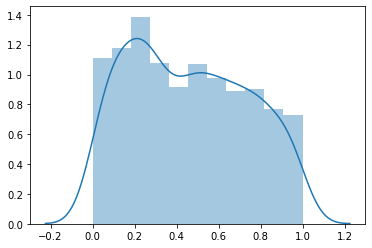

In [99]:
#data in [0,1]
randTrunc=truncnorm.rvs(a=0,b=1,size=numObs)
sns.distplot(randTrunc)

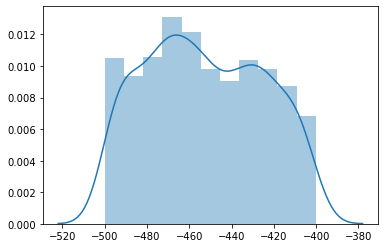

In [110]:
#very negative data
randTruncNegative=truncnorm.rvs(a=0,b=1,loc=-5*10**2,scale= 100, size=numObs)
sns.distplot(randTruncNegative)

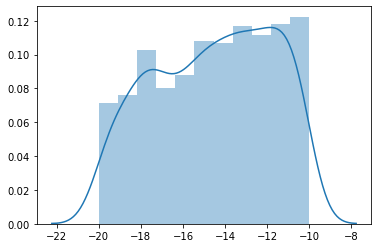

In [113]:
#midly negative
randTruncNegativeMild=truncnorm.rvs(a=-1,b=0,loc=-1*10**1,scale= 10, size=numObs)
sns.distplot(randTruncNegativeMild)

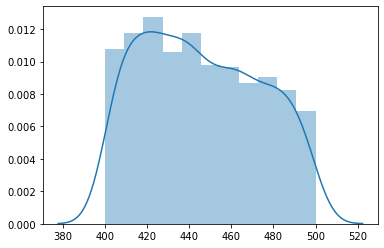

In [116]:
#very positive data
randTruncPositive=truncnorm.rvs(a=0, b=1, loc=4*10**2,scale= 100, size=numObs)
sns.distplot(randTruncPositive)

In [117]:
listRndDataSets=[randTrunc,randTruncNegative, randTruncNegativeMild, randTruncPositive]
listRndDataSetsNames=["randTrunc","randTruncNegative", "randTruncNegativeMild", "randTruncPositive"]

## Tests with leaky relu

In [118]:
leakyInst=LeakyReLU()

In [119]:
class  custLeaky(object):
    
    def __init__(self, **kwargs):
        
        self.leaky = LeakyReLU( **kwargs)
        
        strKw2=[ "{0} = {1}".format(key, value) for key,value in kwargs.items() ] # for some reason the f string is not working like format
        strAllKw= ",".join(strKw2) if len(strKw2) > 0 is not None else 'default'
        self.__name__ = f'leaky_relu_{strAllKw}'
        
    def __call__(self,x):
        return tf.eval(x)
    
    

In [120]:
tf.eval(leakyInst(np.random.randint(0,2,100)) )

array([1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.],
      dtype=float32)

In [121]:
myLeaky=custLeaky(alpha=0.2)
myLeakyDefault=custLeaky()
myLeaky(np.random.randint(0,2,100)) 

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1])

# Test out the effect of the different activations

In [122]:

def testAllActivations(x,titleStr, listAct=[relu, elu, tanh, myLeaky,myLeakyDefault]):
    
    listDf=[]
    for aFct in listAct:
        vals=tf.eval(aFct(x))
        df=pd.DataFrame(vals, columns= ['val'])
        df['id'] = aFct.__name__
        listDf.append(df)
    
    dfAll=pd.concat(listDf)
    sns.violinplot(y='val', x='id', hue='id', data=dfAll)
    plt.title(titleStr)
    
    return pd.concat(listDf)
    

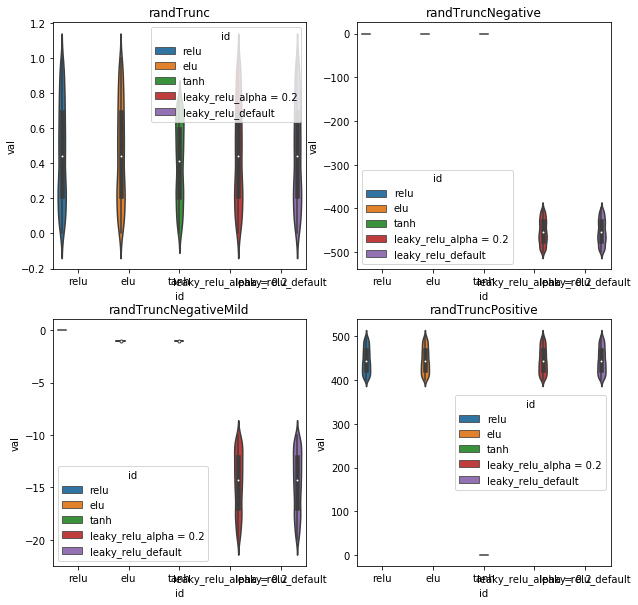

In [123]:
c=0
plt.figure(figsize=(10,10))
for d,n in zip(listRndDataSets,listRndDataSetsNames) :
    plt.subplot(2,2,c+1)
    dfAll=testAllActivations(d,n)
    dfAll.groupby('id').agg('describe')
    c=c+1

## Just the (leaky) (r)elu 

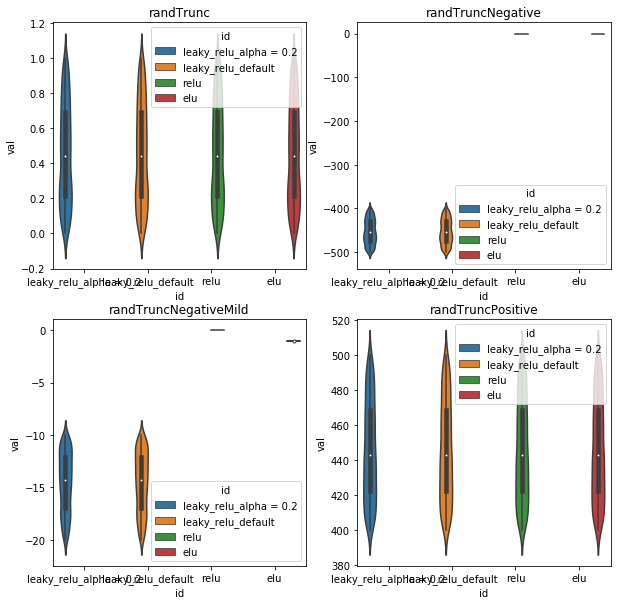

In [129]:
c=0
plt.figure(figsize=(10,10))
for d,n in zip(listRndDataSets,listRndDataSetsNames) :
    plt.subplot(2,2,c+1)
    dfAll=testAllActivations(d,n,listAct=[ myLeaky,myLeakyDefault,relu, elu])
    dfAll.groupby('id').agg('describe')
    c=c+1

## As a fct of the input

In [126]:

def testAllActivationsV2(x,titleStr, listAct=[relu, elu, tanh, myLeaky,myLeakyDefault]):
    
    listDf=[]
    for aFct in listAct:
        vals=tf.eval(aFct(x))
        df=pd.DataFrame(vals, columns= ['val'])
        df['x'] = x
        df['id'] = aFct.__name__
        listDf.append(df)
    
    dfAll=pd.concat(listDf)
    sns.lineplot(y='val', x='x', hue='id', data=dfAll)
    plt.title(titleStr)
    
    return pd.concat(listDf)
    

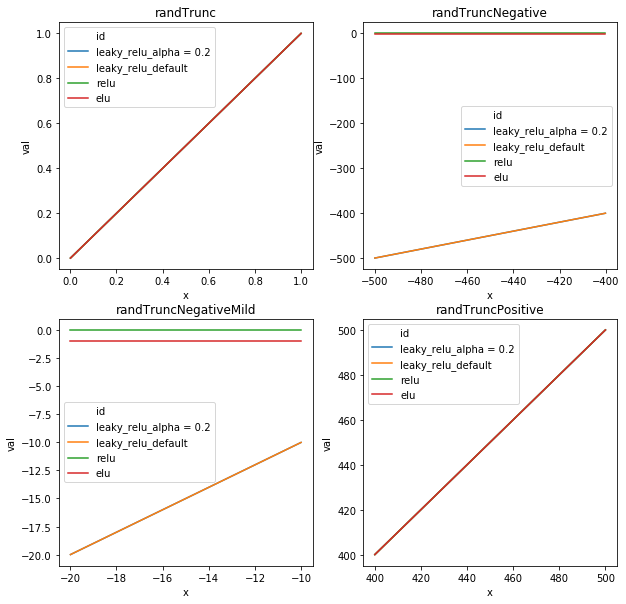

In [130]:
c=0
plt.figure(figsize=(10,10))
for d,n in zip(listRndDataSets,listRndDataSetsNames) :
    plt.subplot(2,2,c+1)
    dfAll=testAllActivationsV2(d,n,listAct=[ myLeaky,myLeakyDefault,relu,elu])
    dfAll.groupby('id').agg('describe')
    c=c+1